<a href="https://colab.research.google.com/github/MarciaSimoes/NLP/blob/main/C%C3%B3pia_de_price_elastic_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# %matplotlib inline

In [ ]:
#IMPORT DATABASE FROM DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_purchase = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/price/purchase_data.csv')
df_customers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/price/customers.csv')

In [ ]:
df_purchase[df_purchase.ID=='200000001'].info()

Data preparation

In [ ]:
df_purchase = df_purchase.drop(columns=['Last_Inc_Brand', 'Last_Inc_Quantity'])

df_purchase['Segment'] = df_purchase['Segment'].map({
    0: 'standard',
    1: 'career-focused',
    2: 'fewer-opportunities',
    3: 'well-off'
})

df_purchase['Mean_Price'] = (df_purchase['Price_1'] + df_purchase['Price_2'] + df_purchase['Price_3'] + df_purchase['Price_4'] + df_purchase['Price_5']) / 5
df_purchase['Has_Promotion'] = (df_purchase['Promotion_1'] + df_purchase['Promotion_2'] + df_purchase['Promotion_3'] + df_purchase['Promotion_4'] + df_purchase['Promotion_5'])

def get_active_price(record):
    if record['Brand'] == 1: return record['Price_1']
    if record['Brand'] == 2: return record['Price_2']
    if record['Brand'] == 3: return record['Price_3']
    if record['Brand'] == 4: return record['Price_4']
    if record['Brand'] == 5: return record['Price_5']
    return 0

df_purchase['Action_Price'] = df_purchase.apply(lambda x: get_active_price(x), axis=1)

df_purchase.head()

,ID,Day,Incidence,Brand,Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Segment,Mean_Price,Has_Promotion,Action_Price
0,200000001,1,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,fewer-opportunities,2.044,1,0.0
1,200000001,11,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,fewer-opportunities,2.028,0,0.0
2,200000001,12,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,fewer-opportunities,2.028,0,0.0
3,200000001,16,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,fewer-opportunities,2.028,0,0.0
4,200000001,18,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,fewer-opportunities,2.030,0,0.0


In [ ]:
LabelEncoder# Distinct brands

np.sort(df_purchase['Brand'].unique())

array([0, 1, 2, 3, 4, 5])

Number of unique customers per segment

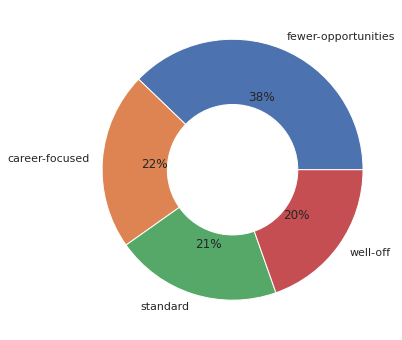

In [ ]:
df_segment = df_purchase[['ID', 'Segment']].drop_duplicates()
segments = df_segment['Segment'].value_counts()

segments.plot.pie(figsize=(6, 6), autopct='%1.0f%%', label='') # startangle=0
p = plt.gcf()
p.gca().add_artist(plt.Circle((0,0), 0.5, color='white'))

plt.show()

Number of incidence (purchase/no-purchase) per Segment

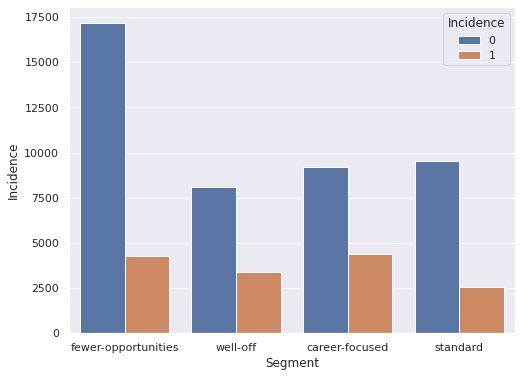

In [ ]:
plt.figure(figsize=(8, 6))
s = sns.countplot(data=df_purchase, x='Segment', hue='Incidence')
plt.xlabel('Segment')
plt.ylabel('Incidence')
plt.show()

Average price and Action price per segment (Focusing on positive purchase incidence only)

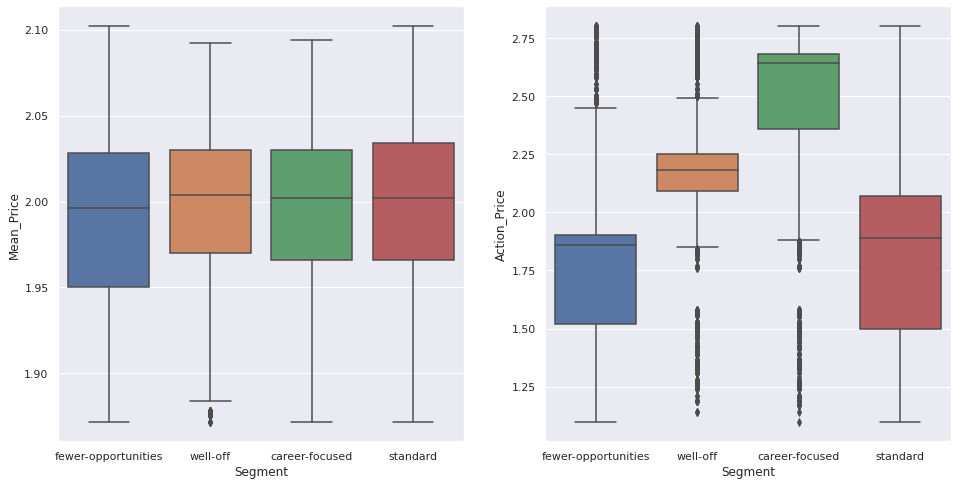

In [ ]:
df_segment_incidence = df_purchase[df_purchase['Incidence'] == 1].copy()
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.boxplot(x='Segment', y='Mean_Price', data=df_segment_incidence, ax=axs[0])
sns.boxplot(x='Segment', y='Action_Price', data=df_segment_incidence, ax=axs[1])
plt.show()

#Logistic Regression

In [ ]:
X = pd.DataFrame()
X['Mean_Price'] = df_purchase['Mean_Price']
y = df_purchase['Incidence']

lr = LogisticRegression(solver='sag')
lr.fit(X, y)

print(lr.coef_)

[[-2.3486121]]


In [ ]:
df_purchase[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [ ]:
price_range = np.arange(0.5, 3.5, 0.01)
df_price_range = pd.DataFrame({'Mean_Price': price_range})

In [ ]:
y_proba = lr.predict_proba(df_price_range)
purchase_proba = y_proba[:][:, 1]

df_purchase_proba = pd.DataFrame({'Purchase_Proba': purchase_proba})
df_price_proba = pd.concat([df_price_range, df_purchase_proba], axis=1)
# df_price_proba.head(50)

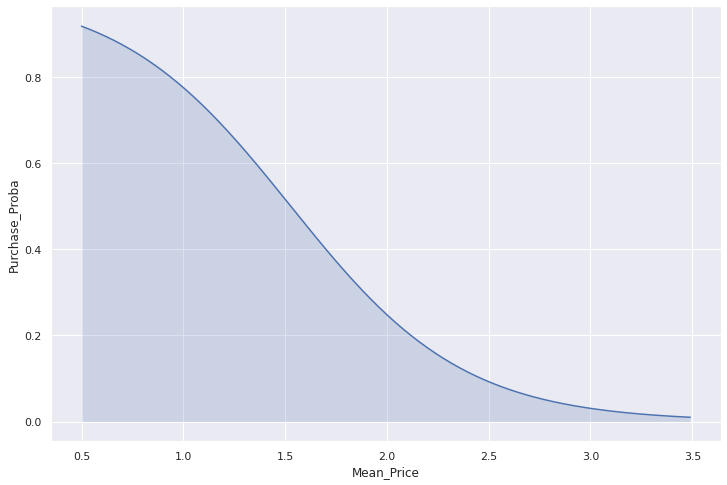

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=df_price_proba, x='Mean_Price', y='Purchase_Proba', ax=ax)
ax.fill_between(data=df_price_proba, x='Mean_Price', y1='Purchase_Proba', alpha=0.2)

plt.show()

#Predicting Price Elasticity of Demand

In [ ]:
pe = lr.coef_[:, 0] * price_range * (1 - purchase_proba)

df_pe = pd.DataFrame({'Mean_Price_Elasticity': pe})
df_price_elasticity = pd.concat([df_price_proba, df_pe], axis=1)
df_price_elasticity

,Mean_Price,Purchase_Proba,Mean_Price_Elasticity
0,0.50,0.917858,-0.096460
1,0.51,0.916070,-0.100531
2,0.52,0.914247,-0.104729
3,0.53,0.912387,-0.109057
4,0.54,0.910492,-0.113519
...,...,...,...
295,3.45,0.010827,-8.014982
296,3.46,0.010579,-8.040235
297,3.47,0.010335,-8.065453
298,3.48,0.010098,-8.090637


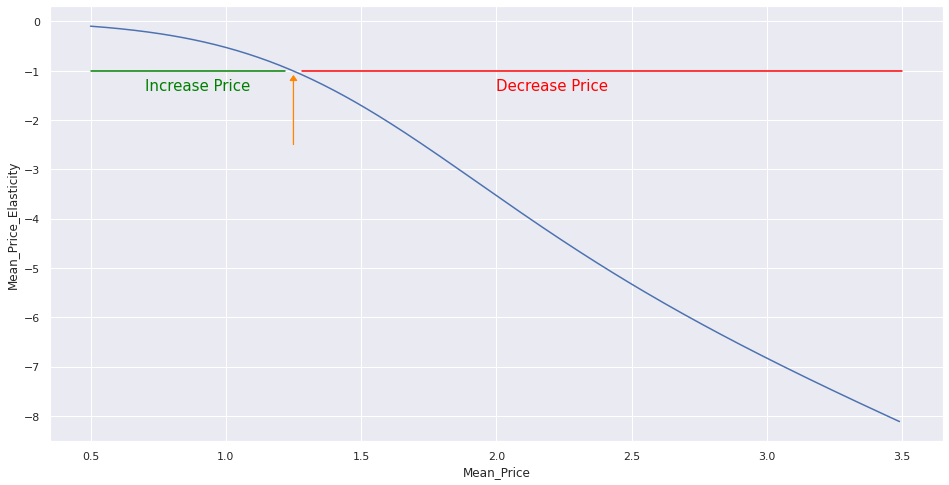

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='Mean_Price_Elasticity', ax=ax)

plt.arrow(1.25, -2.5, 0, 1.3, head_width=0.025, head_length=0.1, color='#FF8400')

plt.plot([0.5, 1.22], [-1, -1], color='green')
plt.annotate("Increase Price", xy=(0.7, -1.4), color='green', fontsize=15)
plt.plot([1.28, 3.5], [-1, -1], color='red')
plt.annotate("Decrease Price", xy=(2.0, -1.4), color='red', fontsize=15)

plt.show()

Compare Price Elasticity by Segment

In [ ]:
seg_list = ['standard', 'career-focused', 'fewer-opportunities', 'well-off']

for seg in seg_list:
    df_data = df_purchase.copy()
    df_data = df_data[df_data['Segment'] == seg]

    X = pd.DataFrame()
    X['Mean_Price'] = df_data['Mean_Price']
    y = df_data['Incidence']

    lr = LogisticRegression(solver='sag')
    lr.fit(X, y)

    y_proba = lr.predict_proba(df_price_range)
    purchase_proba = y_proba[:][:, 1]
    pe = lr.coef_[:, 0] * price_range * (1 - purchase_proba)
    
    df_price_elasticity[seg + '_Price_Elasticity'] = pe


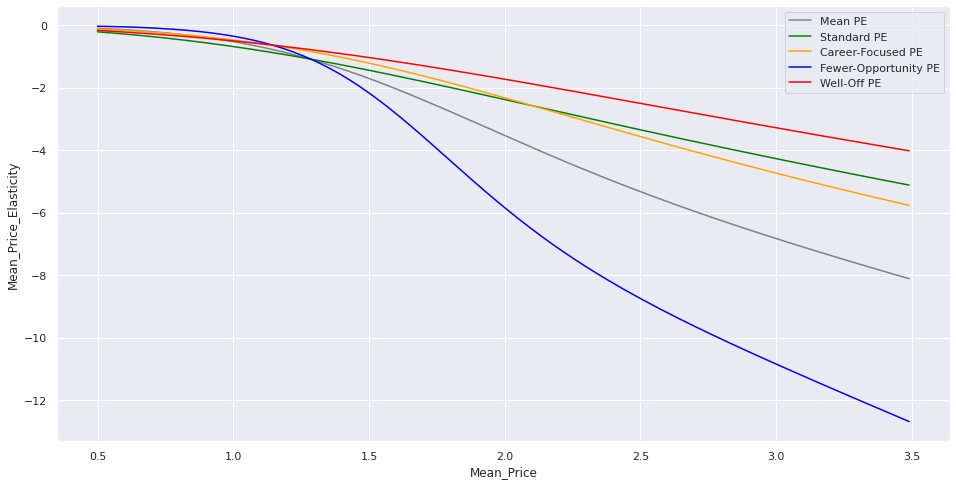

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='Mean_Price_Elasticity', ax=ax, color='gray', label='Mean PE')
sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='standard_Price_Elasticity', ax=ax, color='green', label='Standard PE')
sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='career-focused_Price_Elasticity', ax=ax, color='orange', label='Career-Focused PE')
sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='fewer-opportunities_Price_Elasticity', ax=ax, color='blue', label='Fewer-Opportunity PE')
sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='well-off_Price_Elasticity', ax=ax, color='red', label='Well-Off PE')

plt.show()

In [ ]:
df_price_elasticity

,Mean_Price,Purchase_Proba,Mean_Price_Elasticity,standard_Price_Elasticity,career-focused_Price_Elasticity,fewer-opportunities_Price_Elasticity,well-off_Price_Elasticity
0,0.50,0.917858,-0.096460,-0.211206,-0.118876,-0.030940,-0.166995
1,0.51,0.916070,-0.100531,-0.217777,-0.123055,-0.032708,-0.171866
2,0.52,0.914247,-0.104729,-0.224456,-0.127326,-0.034562,-0.176805
3,0.53,0.912387,-0.109057,-0.231244,-0.131693,-0.036508,-0.181814
4,0.54,0.910492,-0.113519,-0.238141,-0.136155,-0.038549,-0.186892
...,...,...,...,...,...,...,...
295,3.45,0.010827,-8.014982,-5.051955,-5.687209,-12.541143,-3.961741
296,3.46,0.010579,-8.040235,-5.068811,-5.707385,-12.578058,-3.976456
297,3.47,0.010335,-8.065453,-5.085648,-5.727524,-12.614956,-3.991156
298,3.48,0.010098,-8.090637,-5.102467,-5.747627,-12.651838,-4.005841
